# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
#import gdown
import time

## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [2]:
path_root = "C:/Users/Max/Documents/image_data/data_original/Reveton.A/"


Create a dataset from our folder, and rescale the images to the [0-1] range:

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    path_root, label_mode=None, image_size=(64, 64), batch_size=32, interpolation="bicubic", color_mode="rgb"
)
dataset = dataset.map(lambda x: x / 255.0)


Found 1445 files belonging to 1 classes.


Let's display a sample image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


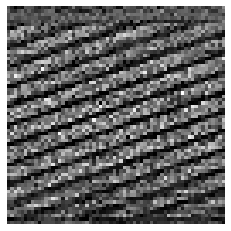

In [4]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [5]:
discriminator = keras.Sequential(
    [
      
        
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same",input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [6]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(latent_dim)),
        
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

## Override `train_step`

In [7]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
        
        


**Other GAN Script**

In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [9]:
def discriminator_loss(real_output, fake_output, d_loss):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_loss.append(total_loss)
    return total_loss

In [10]:
def generator_loss(fake_output, g_loss):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    g_loss.append(fake_loss)
    return fake_loss

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
checkpoint_dir = 'C:/Users/Max/Documents/gan_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Create a callback that periodically saves generated images

In [13]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        start = time.time()
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("C:/Users/Max/Documents/generated_images/generated_img_%03d_%d.png" % (epoch, i))
    
        # Save the model every 5 epochs (WAS 15)
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


## Train the end-to-end model

In [14]:
epochs = 150  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/150
46/46 [==============================] - 14s 231ms/step - d_loss: 0.5804 - g_loss: 0.9160
Time for epoch 1 is 0.2838144302368164 sec
Epoch 2/150
46/46 [==============================] - 10s 218ms/step - d_loss: 0.5644 - g_loss: 1.6305
Time for epoch 2 is 0.04466509819030762 sec
Epoch 3/150
46/46 [==============================] - 10s 219ms/step - d_loss: 0.2332 - g_loss: 8.7775
Time for epoch 3 is 0.04300069808959961 sec
Epoch 4/150
46/46 [==============================] - 10s 220ms/step - d_loss: 1.5194 - g_loss: 1.8719
Time for epoch 4 is 0.04500436782836914 sec
Epoch 5/150
46/46 [==============================] - 10s 221ms/step - d_loss: 0.1327 - g_loss: 5.9280
Time for epoch 5 is 0.046141862869262695 sec
Epoch 6/150
46/46 [==============================] - 11s 229ms/step - d_loss: 0.4825 - g_loss: 5.2461
Time for epoch 6 is 0.05500078201293945 sec
Epoch 7/150
46/46 [==============================] - 11s 232ms/step - d_loss: 0.4813 - g_loss: 1.2352
Time for epoch 7 is 0.

46/46 [==============================] - 12s 254ms/step - d_loss: 0.3984 - g_loss: 1.8901
Time for epoch 56 is 0.039769649505615234 sec
Epoch 57/150
46/46 [==============================] - 11s 246ms/step - d_loss: 0.3433 - g_loss: 2.0649
Time for epoch 57 is 0.040003299713134766 sec
Epoch 58/150
46/46 [==============================] - 13s 276ms/step - d_loss: 0.3480 - g_loss: 2.1774
Time for epoch 58 is 0.04971432685852051 sec
Epoch 59/150
46/46 [==============================] - 13s 270ms/step - d_loss: 0.3438 - g_loss: 2.1122
Time for epoch 59 is 0.04000234603881836 sec
Epoch 60/150
46/46 [==============================] - 11s 238ms/step - d_loss: 0.3217 - g_loss: 2.0595
Time for epoch 60 is 0.09599757194519043 sec
Epoch 61/150
46/46 [==============================] - 11s 235ms/step - d_loss: 0.3195 - g_loss: 1.9981
Time for epoch 61 is 0.039003610610961914 sec
Epoch 62/150
46/46 [==============================] - 11s 231ms/step - d_loss: 0.3283 - g_loss: 2.1447
Time for epoch 62 i

46/46 [==============================] - 12s 259ms/step - d_loss: 0.2540 - g_loss: 2.1161
Time for epoch 111 is 0.03899836540222168 sec
Epoch 112/150
46/46 [==============================] - 13s 281ms/step - d_loss: 0.2956 - g_loss: 2.0321
Time for epoch 112 is 0.04999828338623047 sec
Epoch 113/150
46/46 [==============================] - 14s 301ms/step - d_loss: 0.3399 - g_loss: 1.9231
Time for epoch 113 is 0.04099917411804199 sec
Epoch 114/150
46/46 [==============================] - 12s 261ms/step - d_loss: 0.2985 - g_loss: 2.0656
Time for epoch 114 is 0.038999319076538086 sec
Epoch 115/150
46/46 [==============================] - 12s 259ms/step - d_loss: 0.2742 - g_loss: 2.0557
Time for epoch 115 is 0.039002180099487305 sec
Epoch 116/150
46/46 [==============================] - 11s 226ms/step - d_loss: 0.2623 - g_loss: 2.1665
Time for epoch 116 is 0.0390009880065918 sec
Epoch 117/150
46/46 [==============================] - 17s 364ms/step - d_loss: 0.2790 - g_loss: 2.1314
Time for 

Some of the last generated images around epoch 30
(results keep improving after that):


# Checkpoint Restore

In [15]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))